<h1 align='center'> Monte-Carlo (MCMC) - TP6 (Homework due April 28 23h59) </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>


In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

## I - Metropolis-Hastings vs Rejection sampling
We would like to sample from the density function:
$$ f(x) \propto  x^4\exp(- x^2) $$ 
Using the proposal: $g(x) \propto \exp(- \frac{1}{2} x^2) $.

1. Find an empirical bound M so as to apply rejection sampling using g to sample from f and visualize the domination of f by Mg.

# Answer

We assume that the normalising constant is equal to 1.
We want to find $M$ such that $Mg \geq f$ which implies $M \geq h$ where $h: x \to x^{4}exp(-\frac{x^{2}}{2})$

It suffices to find a global maximum of h.
We differentiate h and eventually find the root at $x=2$ and it suffices to evaluate M at that value : we get $M=exp(2)$

In [3]:
x = np.linspace(-10, 10, 1000)
f = lambda x: np.exp(- x ** 2) * x ** 4
g = lambda x: np.exp(- 0.5 * x ** 2)

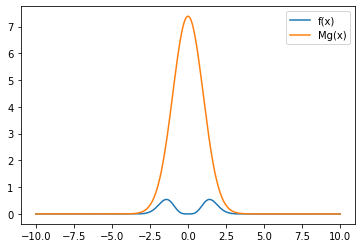

In [38]:
M=np.exp(2)

plt.plot(x, [f(i) for i in x], label='f(x)')
plt.plot(x, [M*g(i) for i in x], label='Mg(x)')
plt.legend()
plt.show()

2. Implement the rejection sampling algorithm and visualize the empirical histogram against the density f. Use scipy.integration to estimate the normalizing constant of f for accurate visualization of the density.

In [39]:
def rejection_sampling():
    """Reject sampling algorithm for f with Gaussian proposal g."""
    while True:
        y = np.random.normal()
        u = np.random.uniform(0,1)
        if u < f(y) / (M * g(y)):
            return y

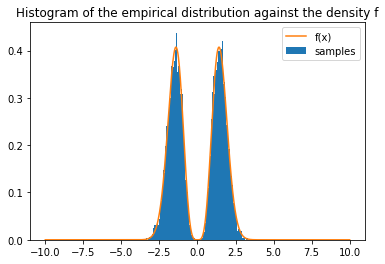

In [84]:
import scipy.integrate as spi   

nc=spi.quad(f,-np.inf,np.inf)[0]

#plot histogram of f/nc
rej_samples = [rejection_sampling() for i in range(10000)]
plt.hist(rej_samples, bins=100, density=True, label="samples")
plt.plot(x, [f(i)/nc for i in x], label='f(x)')
plt.title("Histogram of the empirical distribution against the density f")
plt.legend()
plt.show()

3. Implement the random walk metropolis hastings algorithm with a Gaussian conditional probability and visualize the empirical histogram against the normalized density f/F

For the random walk metropolis hastings algorithm, we sample from a centered gaussian distribution of variance 0.4.

/Users/haouabenaliabbo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


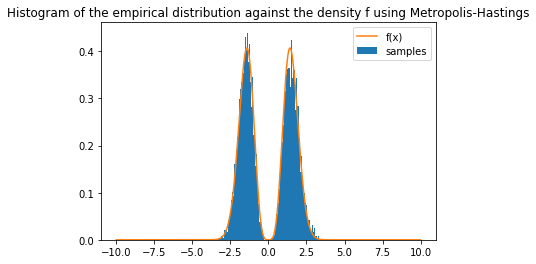

In [96]:
def rw_metropolis_hastings(n, f=f, seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    seed: int (optional).
        random seed initialization.
    """
    np.random.seed(seed)
    x=0
    samples=[x]
    for i in range(n):
        y=np.random.normal(x,np.sqrt(0.4))
        alpha=f(y)/f(x)
        u=np.random.uniform(0,1)
        if alpha>=u:
            x=y
        samples.append(x)
    return samples[1:]
    

MH_samples=rw_metropolis_hastings(10000)
plt.hist(MH_samples, bins=100, density=True, label="samples")
plt.plot(x, [f(i)/nc for i in x], label='f(x)')
plt.title("Histogram of the empirical distribution against the density f using Metropolis-Hastings")
plt.legend()
plt.show()


# II - Gibbs sampling
Gibbs sampling is a Markov Chain sampling algorithm used to sample from a multivariate random variable by sampling each component from its conditional distribution while the others components are fixed.

We would like to sample from a multivariate Gaussian $(X_1, X_2)$ with density:
$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$
*1. Identify the parameters of the distribution and compute the conditional distributions of each component.*

# Answer 

X follows a normal multivariate distribution :
$X=(X_{1},X_{2}) \sim N(0,\Sigma)$ where the covariance matrix 
$\Sigma= \begin{bmatrix}
1 & \rho \\
\rho & 1 
\end{bmatrix}$

The conditional distributions write : 
$X_{1} | X_{2} \sim N(\rho X_{2}, (1-\rho ^{2}))$ and $X_{2} | X_{1} \sim N(\rho X_{1}, (1-\rho ^{2}))$



*2. Implement the associated Gibbs sampler where each $X_1, X_2$ are sampled sequentially from the conditional distributions.*

In [23]:
rho=0.4

def gibbs_sampler(n, rho=rho):
    """Gibbs sampler for (X_1, X_2)."""
    x1,x2 = 0, 0
    samples=np.zeros((n,2))
    for i in range(n):
        x1=np.random.normal(rho*x2,np.sqrt(1-rho**2))
        samples[i,0]=x1
        x2=np.random.normal(rho*x1,np.sqrt(1-rho**2))
        samples[i,1]=x2
    return samples

3. Visualize the contour plots of the target distribution and that of the Gibbs Sampler for different values of n. How does it behave with $\rho$ ?

First the target density:

/Users/haouabenaliabbo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


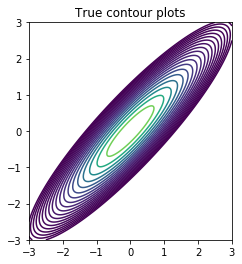

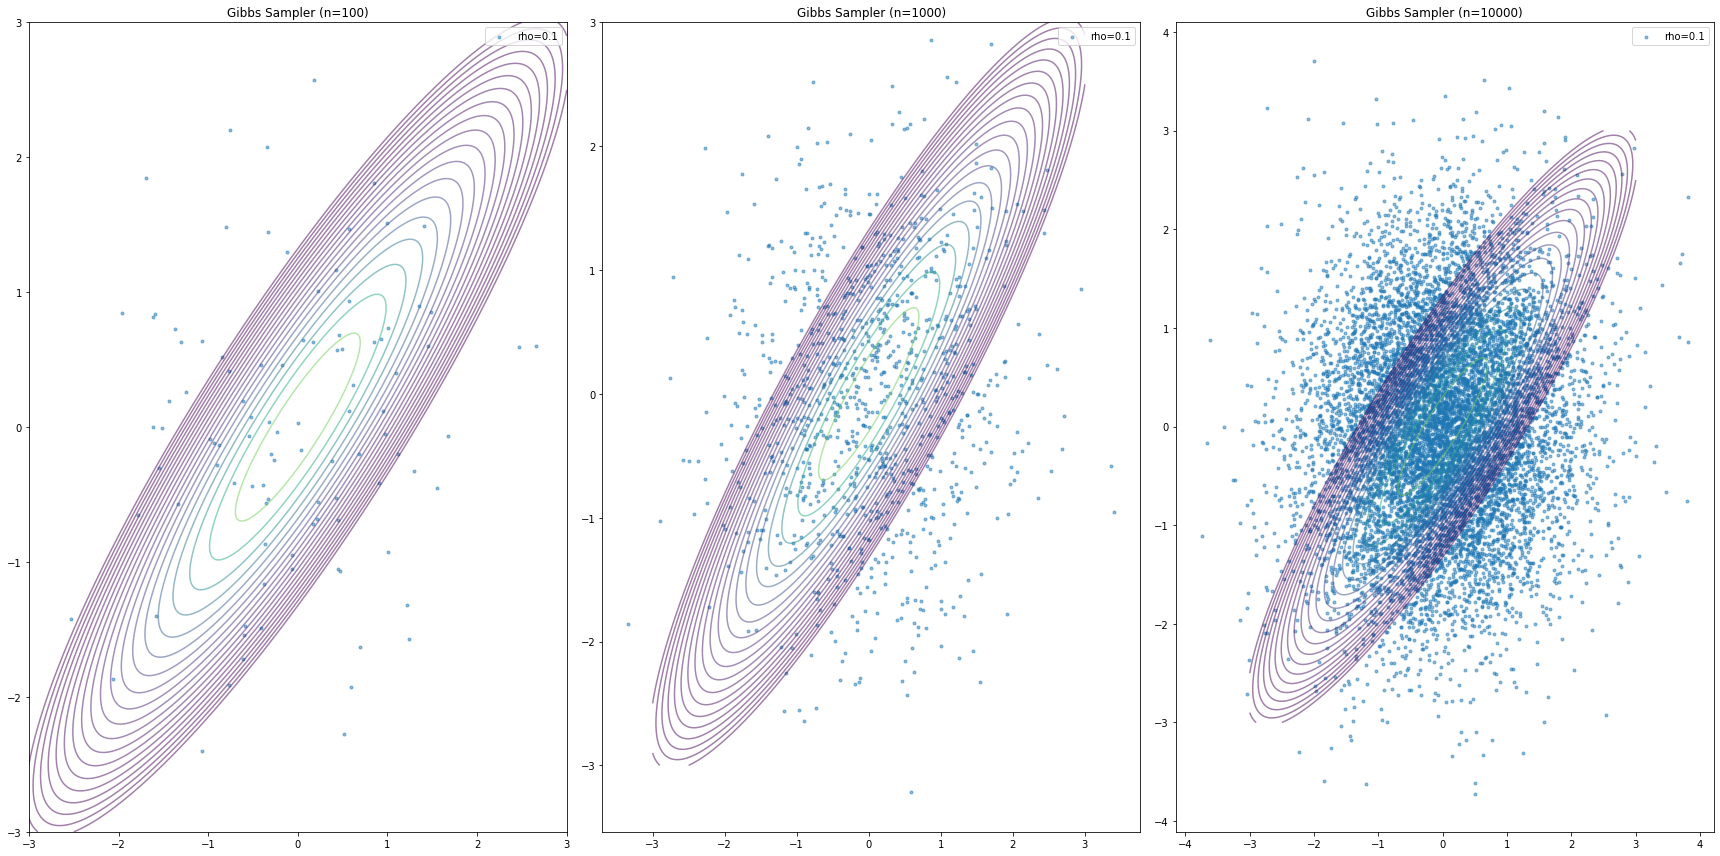

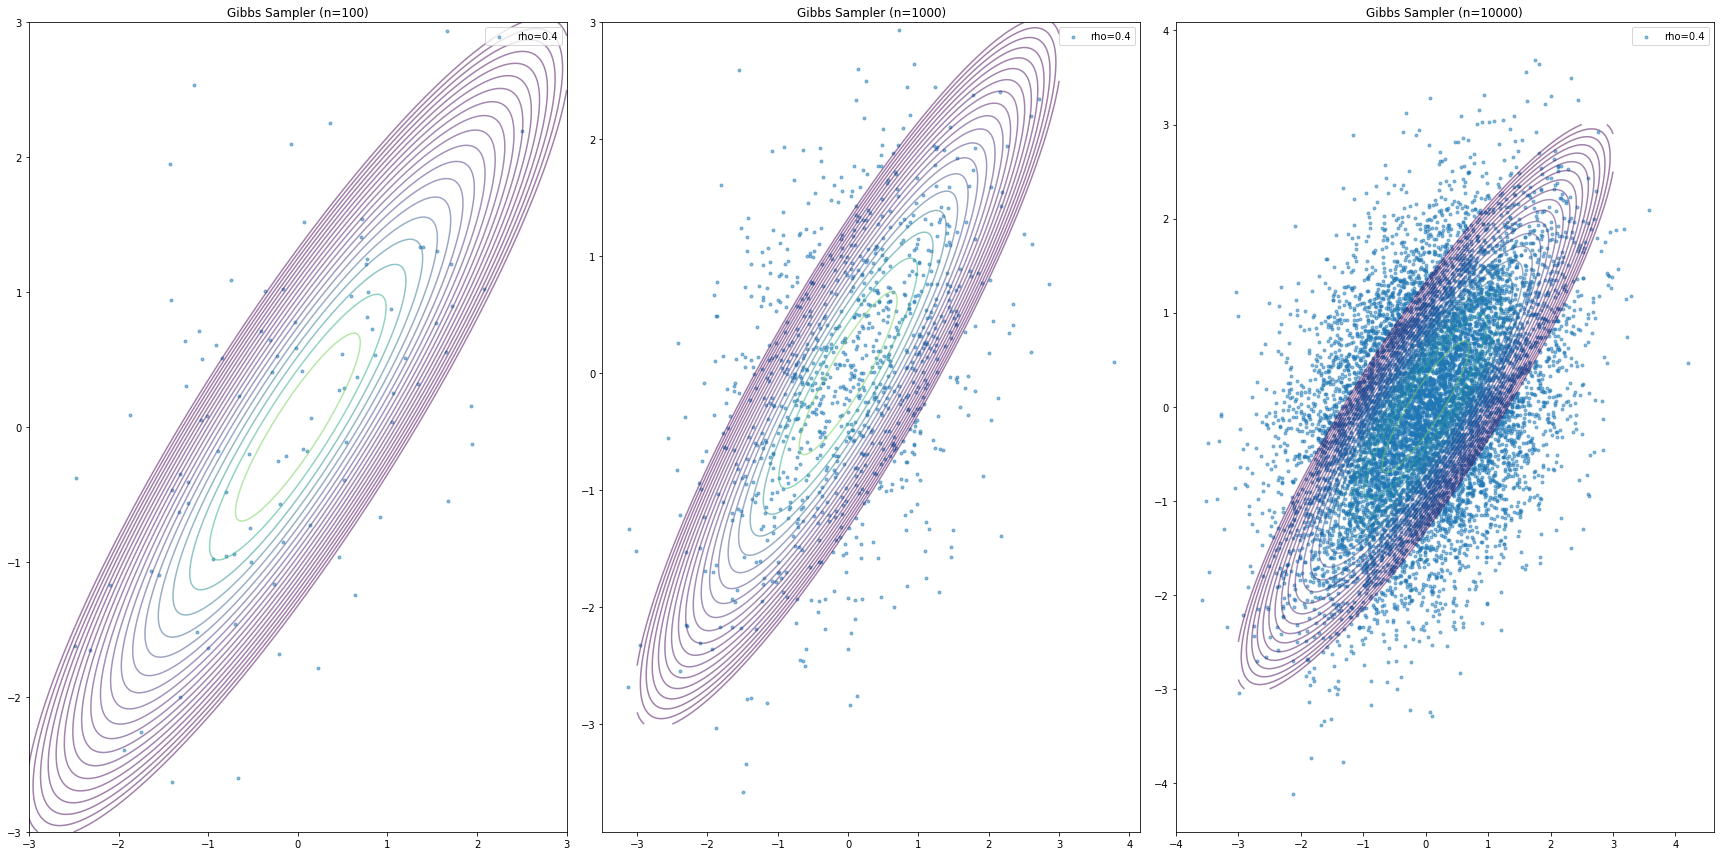

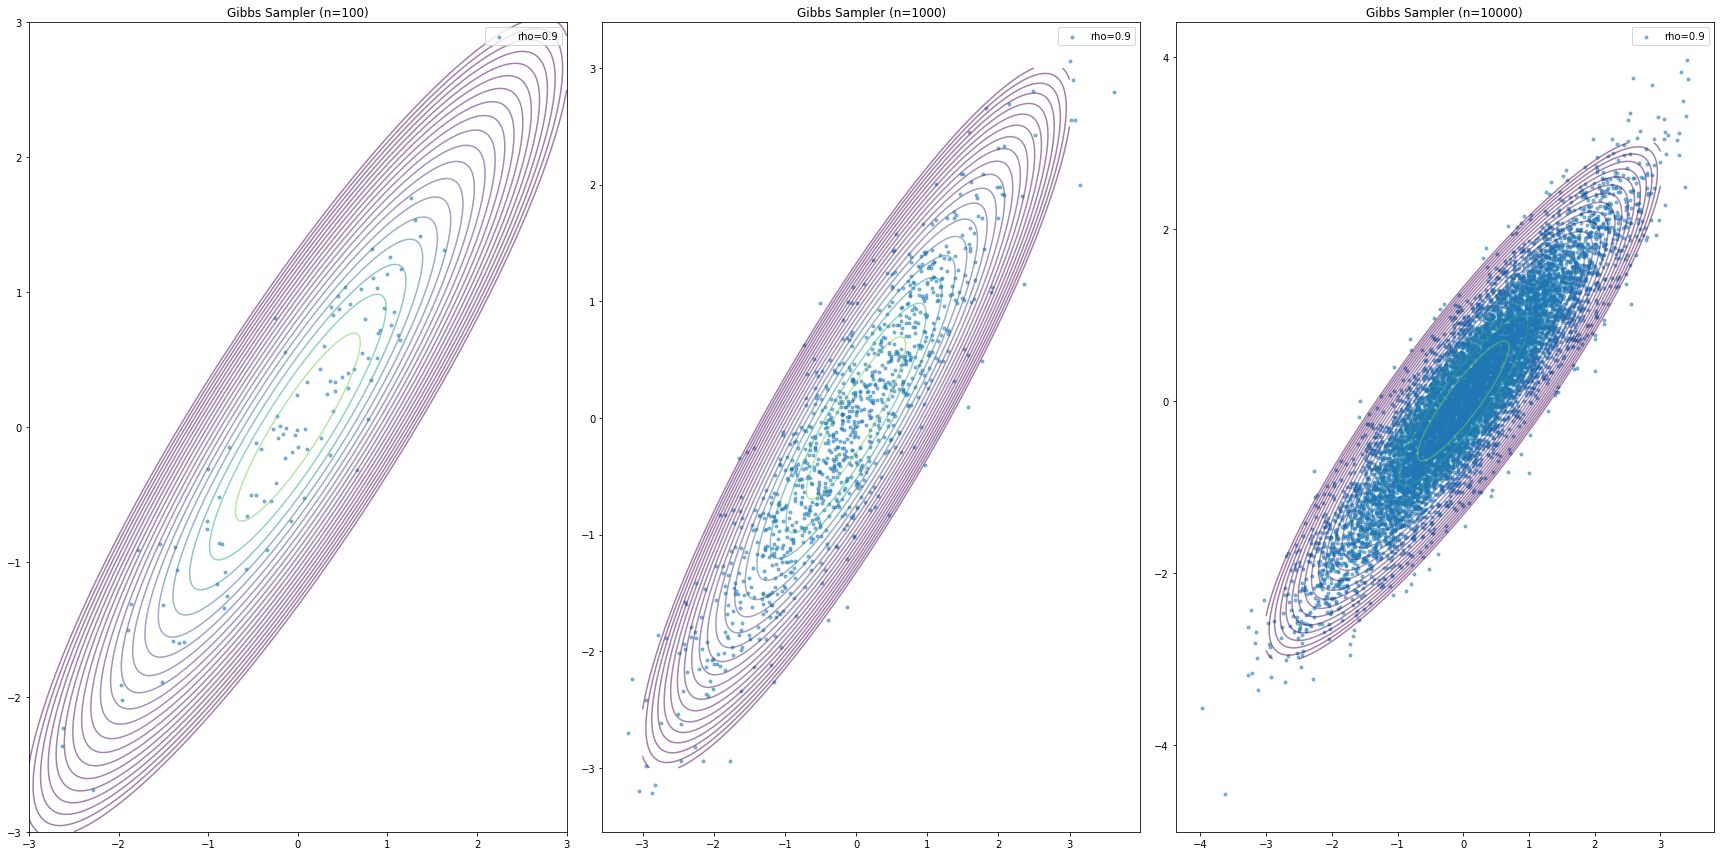

In [46]:
from scipy.stats import multivariate_normal
S = np.array([[1, rho], [rho, 1]])
grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)
pos = np.empty((1000, 1000, 2))
pos[:, :, 0] = x
pos[:, :, 1] = y
Z_true = multivariate_normal.pdf(pos, mean=[0, 0], cov=S)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")

n_values = [100, 1000, 10000]
rho_values=[0.1,0.4,0.9]
for j,rho in enumerate(rho_values):
    plt.figure(figsize=(24, 12))
    plt.subplot(1,len(rho_values),j+1)
    for i, n in enumerate(n_values):
        plt.subplot(1, len(n_values), i+1)
        samples = gibbs_sampler(n, rho)
        plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max(), alpha=0.5)
        plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.5, label=f"rho={rho}")
        plt.legend()
        plt.title(f"Gibbs Sampler (n={n})")
    plt.tight_layout()
    plt.show()

# Answer

We observe that if the iteration number is not high enough (we sample few data), it is not clear that the sample was effectively drawn from the target distribution. 

Also, as $\rho \to 1$, the samples tend to belong to the contour, which proves that the guess matches the correct distribution.

The most precise samples are get for high values of n (many draws) and $\rho \approx 1$.

Now we plot the contour plots as the Markov chain moves. Keep in mind that the Markov chain samples are correlated and therefore not iid ! We need to wait a whiler until the MC reaches the stationary distribution. We show this in the following plots:
First we plot everything till a certain iteration:

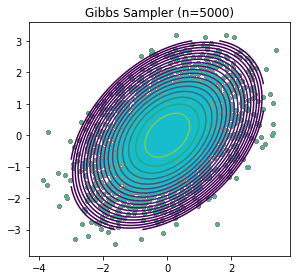

In [7]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max())
plt.title("True contour plots")

n_max=5000
samples = gibbs_sampler(n_max, rho)
for i in range(n_max):
    plt.scatter(samples[:i,0], samples[:i,1], marker='.', alpha=0.5)
plt.title(f"Gibbs Sampler (n={n_max})")

plt.tight_layout()
plt.show()

4. Using the numpy corrcoef function, plot the auto-correlation values as a function of the lag: $corr(X_t, X_{t - lag})$

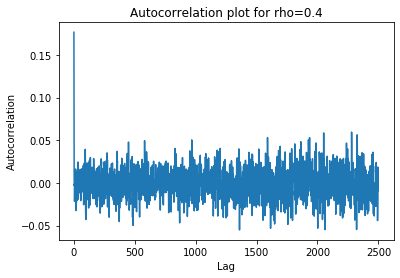

In [29]:

samples=gibbs_sampler(n_max, 0.4)
autocorrelation = []
lags = range(1, n_max//2)  
for lag in lags:
    corr_matrix = np.corrcoef(samples[:-lag, 0], samples[lag:, 0])
    autocorrelation.append(corr_matrix[0, 1])

plt.plot(lags, autocorrelation)
plt.title("Autocorrelation plot for rho=0.4")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

5. Using what you observe, propose two arguments to add to your Gibbs sampler function to improve the simulation.
What happens when $\rho \to 1$ ?

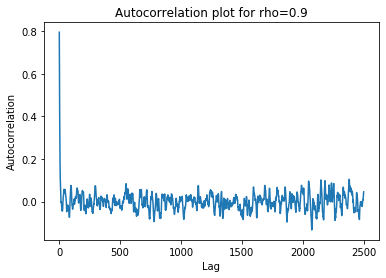

In [28]:
samples=gibbs_sampler(n_max,0.9)
autocorrelation2 = []
for lag in range(1, n_max//2):  # You can adjust the range according to your preference
    corr_matrix = np.corrcoef(samples[:-lag, 0], samples[lag:, 0])
    autocorrelation2.append(corr_matrix[0, 1])

# Plot autocorrelation
plt.plot(range(1, n_max//2), autocorrelation2)
plt.title("Autocorrelation plot for rho=0.9")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

# Answer

When $\rho \to 1$, the autocorrolation function gets smoother : we have less variance.

6. Implement a Random Walk metropolis algorithm to simulate from p using a conditional proposal $\mathcal N(0, \tau I_2)$ and vary $\tau$. 

$$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1 - \rho^2}} \exp\left(- \frac{1}{2(1 - \rho^2)}(x_1^2 + x_2^2 - 2\rho x_1 x_2)\right) $$

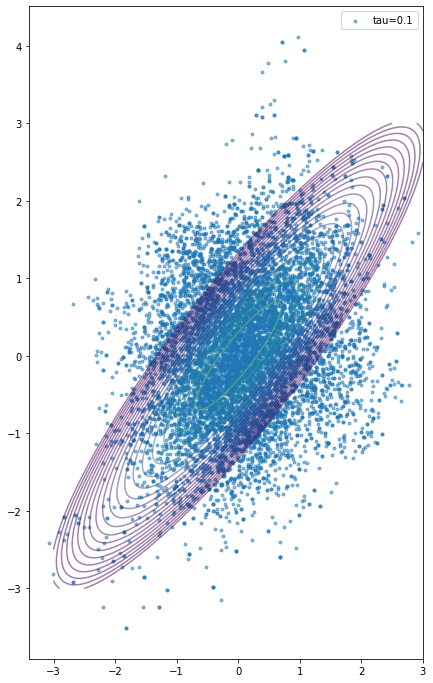

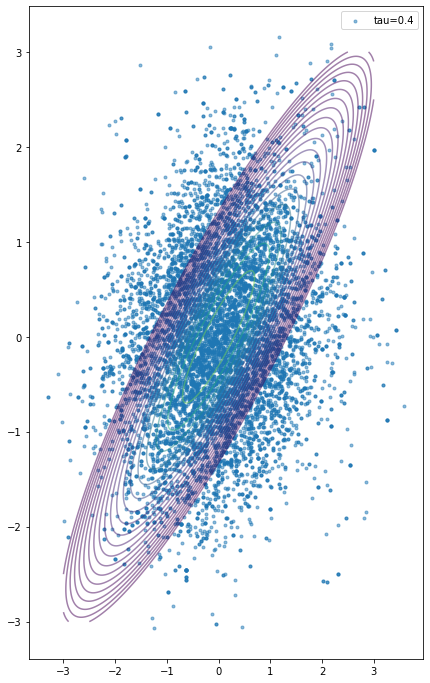

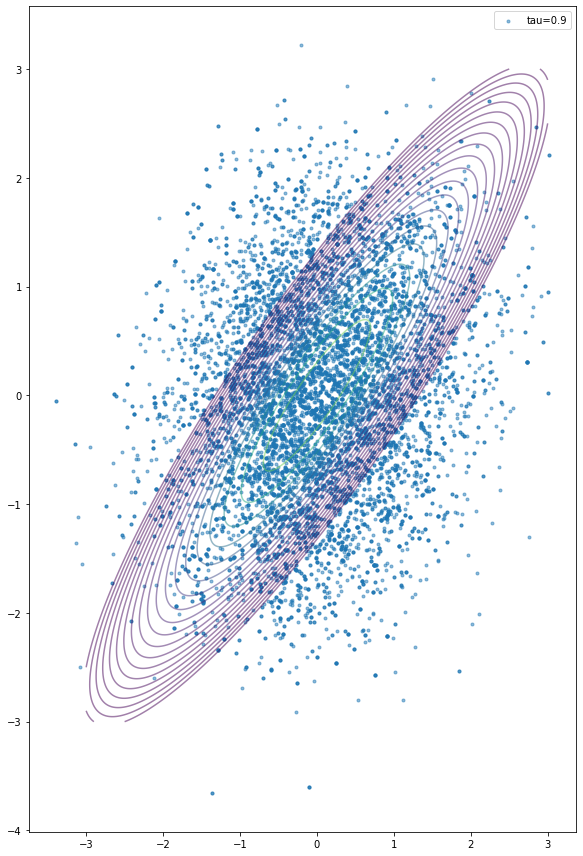

In [47]:
tau=0.4

def rw_metropolis_hastings(n, f, tau=1., seed=None):
    """Random walk metropolis hastings algorithm for f with Gaussian proposal g."""
    np.random.seed(seed)
    x1,x2=0,0
    samples=np.zeros((n,2))
    for i in range(n):
        y1,y2=np.random.multivariate_normal([x1,x2],[[tau,0],[0,tau]])
        alpha=f(y1,y2)/f(x1,x2)
        u=np.random.uniform(0,1)
        if alpha>=u:
            x1,x2=y1,y2
        samples[i,0]=x1
        samples[i,1]=x2
    return samples

def p(x1,x2,tau=tau):
    return (1/(2*np.pi)*np.sqrt(1-tau**2))*np.exp(-0.5*(x1**2+x2**2-tau*x1*x2)/(1-tau**2))  

tau_values=[0.1,0.4,0.9]

for i,t in enumerate(tau_values):
    plt.figure(figsize=(24, 12))
    plt.subplot(1,len(tau_values),i+1)
    samples=rw_metropolis_hastings(10000,p,t)
    plt.contour(x, y, Z_true, levels=np.logspace(-2, 0., 20) * Z_true.max(), alpha=0.5)
    plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.5, label=f"tau={t}")
    plt.legend()

plt.tight_layout()
plt.show()

We observe that this method is less precise than the Gibbs sampler!